In [1]:
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise

## Extract Background
### Running Average
This will be used  the segment the foreground from the background

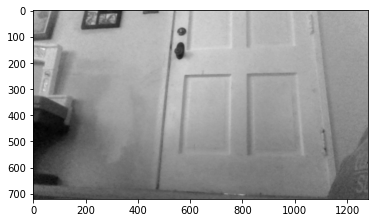

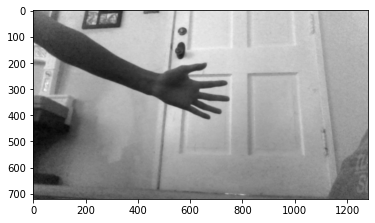

In [2]:
# read in images
background = cv2.imread("images/no_hand.jpg")
foreground = cv2.imread("images/yes_hand.jpg") 

# turn to garyscale because color isn't important for this
gray_back = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)
gray_fore = cv2.cvtColor(foreground, cv2.COLOR_BGR2GRAY)

# blur to smooth things out
gray_back = cv2.GaussianBlur(gray_back, (7, 7), 0)
gray_fore  = cv2.GaussianBlur(gray_fore, (7, 7), 0)

plt.imshow(gray_back, cmap='gray')
plt.show()

plt.imshow(gray_fore, cmap='gray')
plt.show()

In [3]:
gray_back.shape # its an array of 720 rows, 1280 columns, and 3 layers/channels

(720, 1280)

In [4]:
# change to float, doesn't work with int
average = cv2.accumulateWeighted(gray_back.astype("float"), gray_back.astype("float"), 0.5)
display(average.shape) # still the same dimensions

(720, 1280)

In [5]:
# manual calculation of accumulateWeighted
manual_average = ((1-0.5)*gray_back) + (0.5 * gray_back)
print((manual_average == average).all()) # exactly the same
print((average == gray_back).all()) # since we used the same image, the average should just be background

True
True


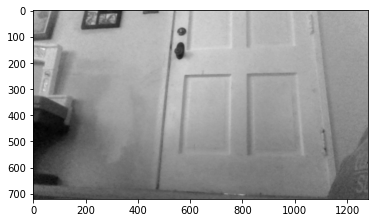

In [6]:
plt.imshow(average.astype("int"), cmap='gray') # change back to int because it used to be float and imshow requires range 0-255 ints
plt.show()

### Background Subtraction

[[46 46 45 45 44]
 [45 46 45 45 44]
 [44 44 44 44 43]
 [41 41 41 41 40]
 [37 38 37 37 36]]


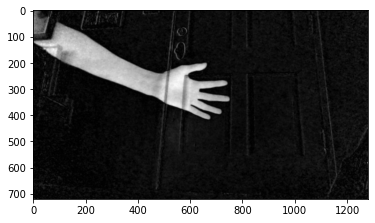

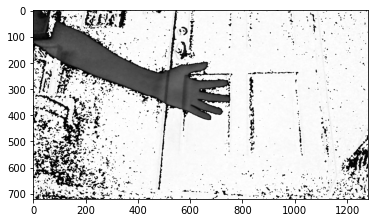

In [7]:
# calculate the difference between background and foreground
diff = cv2.absdiff(gray_back, gray_fore)
print(diff[:5,:5,])
plt.imshow(diff, cmap='gray')
plt.show()

manual_diff = abs(gray_back - gray_fore) # different because cv2.absdiff performs saturation
plt.imshow(manual_diff, cmap='gray')
plt.show()

Here we see that pixels with more similar values are darker than non-similar values
### Threshold
Any pixel that is over the threshold turns white. Since we did background substraction, the foreground should
have the highest values and thus be white.

In [1]:
threshold = cv2.threshold(diff, 23, maxval=255, type=cv2.THRESH_BINARY)[1] # this returns a tuple (threshold, thresholded image)

plt.imshow(threshold, cmap='gray')
plt.show()

NameError: name 'cv2' is not defined

### Create an Arbitrary Region of Intrest
Create a rectangle than encloses the hand

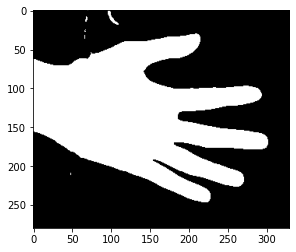

In [9]:
top, bottom, left, right = 170, 450, 450, 780
roi = threshold[top:bottom, left:right]
plt.imshow(roi, cmap='gray')
plt.show()
#cv2.rectangle(clone, (left, top), (right, bottom), (0,255,0), 2)

### Contour
Extract the contour to find the convex hull, which will then be used to create a circle than "represents" the hand

In [2]:
shift = np.array([left,top], ndmin=3)

NameError: name 'np' is not defined

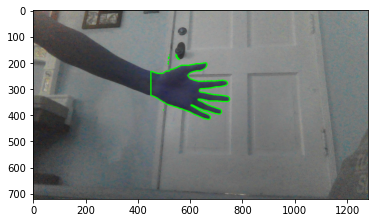

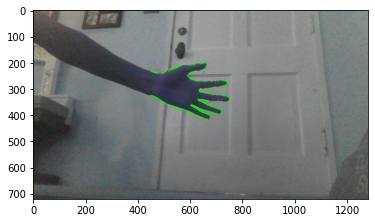

In [11]:
# find contours from our threshold image
# contours is a list of contours, but we don't want all the contours, we just want the biggest because we assume that's the hand.
contours, hierarchy = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # returns the tuple (contours, hierarchy)

# retrieves largest contour from contours
biggest_contour = max(contours, key=cv2.contourArea)

shifted_contours = [contours[i] + shift for i in range(len(contours))]
    
# draw all contours
f_cpy = foreground.copy()
cv2.drawContours(f_cpy, shifted_contours, -1, (0,255,0), 4) # we draw the contours on a copy of the foreground image
plt.imshow(f_cpy)
plt.show()

# draw the biggest contour
f_cpy = foreground.copy()
cv2.drawContours(f_cpy, biggest_contour+np.array([450,170], ndmin=3) , -1, (0,255,0), 4)  # we draw the contours on a copy of the foreground image
plt.imshow(f_cpy)
plt.show()

### Convex Hull

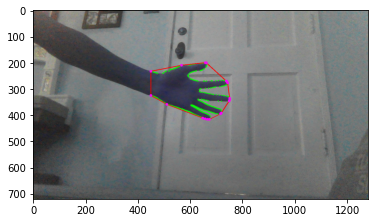

In [12]:
convex_hull = cv2.convexHull(biggest_contour, False)
# use old image
cv2.drawContours(f_cpy, [convex_hull+np.array([450,170], ndmin=3)], -1, (255,0,0), 2) # put convex_hull into a list in order to draw convex hull
cv2.drawContours(f_cpy, convex_hull+np.array([450,170], ndmin=3), -1, (255,0,255), 10) # if not in list, gives points that define convex hull
plt.imshow(f_cpy)
plt.show()

### Obtain Extreme Points of Convex Hull
The extreme points will be used to create the circle

In [3]:
# y-axis is the second layer
extreme_top = convex_hull[convex_hull[:,:,1].argmax()][0][1]
extreme_bottom = convex_hull[convex_hull[:,:,1].argmin()][0][1]

# x-axis is the first layer
extreme_right = convex_hull[convex_hull[:,:,0].argmax()][0][0]
extreme_left = convex_hull[convex_hull[:,:,0].argmin()][0][0]

print("Extreme Top:", extreme_top)
print("Extreme Bottom:",extreme_bottom)
print("Extreme Right:", extreme_right)
print("Extreme Left:",extreme_left)

NameError: name 'convex_hull' is not defined

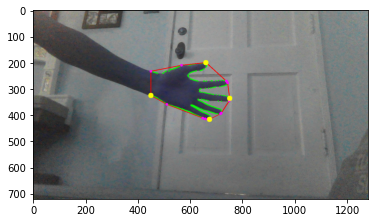

In [14]:
extreme_index = []
for k in [0,1]:
    extreme_index.append(convex_hull[:,:,k].argmax())
    extreme_index.append(convex_hull[:,:,k].argmin())

for i in extreme_index:
    cv2.drawContours(f_cpy, convex_hull+shift, i, (255,255,0), 20) # no copy, add onto previous image

plt.imshow(f_cpy)
plt.show()

### Find Center of Palm
To eventually create a circle around the hand

In [15]:
cX = int((extreme_left + extreme_right) / 2)
cY = int((extreme_top + extreme_bottom) / 2)
cX,cY

(150, 138)

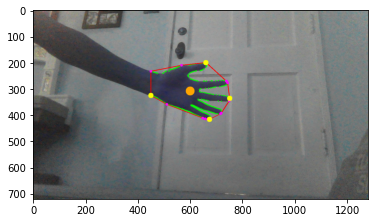

In [16]:
cv2.circle(f_cpy, (cX+shift[:,:,0], cY+shift[:,:,1]), radius=17, color=(255, 165, 0), thickness=-1)
plt.imshow(f_cpy)
plt.show()

### Make Circle of Hand
This circle will be used as a mask to find parts of the hand the overlap with it

In [17]:
# calculate distance from center to extreme distances (yellow)
distances = pairwise.euclidean_distances([(cX,cY)], (convex_hull[extreme_index])[:,0,:])
distances

array([[153.57408636, 150.96025967, 130.91982279, 123.54756169]])

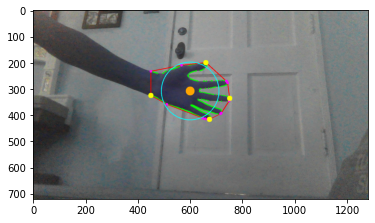

In [18]:
# use largest distance to create circle
largest_dist = distances[0][distances[0].argmax()]
radius = int(largest_dist*0.72)

cv2.circle(f_cpy, (cX+shift[:,:,0], cY+shift[:,:,1]), radius=radius, color=(0,255,255), thickness=2) # decrease radius to 72%
plt.imshow(f_cpy)
plt.show()

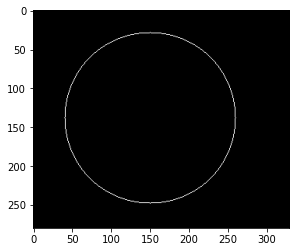

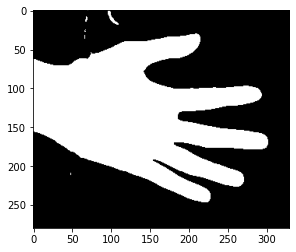

In [19]:
black = np.zeros(roi.shape[:2], dtype="uint8") # creates and array the same shape and roi filled with zeros
circular_roi = black.copy()
cv2.circle(circular_roi, (cX, cY), radius, 255, 1) # draws white circle on the black background
plt.imshow(circular_roi, cmap='gray')
plt.show()

#reminder of what roi looks like
plt.imshow(roi, cmap='gray')
plt.show()

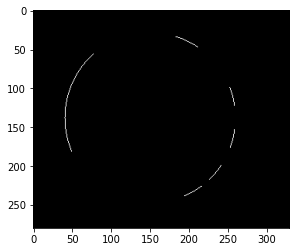

In [20]:
# only show the circle that overlaps the hand
circular_roi = cv2.bitwise_and(roi, roi, mask=circular_roi) 
plt.imshow(circular_roi, cmap='gray')
plt.show()

### Count Fingers
The contours seen above represent areas where the circle and hand intersects. We see that it intersects the 5 fingers and wrist. We just need to count up the contours minus the wrist

In [21]:
# find the contours
(finger_contours, _) = cv2.findContours(circular_roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
len(finger_contours) # fingers contain part of the wrist, so we may need to remove it somehow

6

In [22]:
# count the contours that is not the wrist and not too big 
# (fingers should only take up a small ammount of the circumfrance)
circumference = radius * np.pi * 2

# initialize count
count = 0

for cnt in finger_contours:
    if cv2.arcLength(cnt,False) < (0.20 * circumference):
        count += 1

print("Number of Fingers:", count)

Number of Fingers: 5
